In [1]:
# G-Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#The Root path of our G-drive
root_path = "/content/drive/MyDrive/Final"

### installing all required libs

In [2]:
!pip install -r "/content/drive/MyDrive/Final/requirements.txt"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Merging datasets

In [3]:
import os
from copy import deepcopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def load_data(paths, sep=None, merged_df_col_names=None):
  df = pd.DataFrame()
  output = []
  merged_df = pd.DataFrame()
  for path in paths:
      if sep is not None:
        df = pd.read_csv(path, sep=sep)
      else:
        df = pd.read_csv(path)

      if len(merged_df):
        merged_df = pd.concat([merged_df, deepcopy(df)])
      else:
        merged_df = deepcopy(df)
      output.append([path.split("/")[-1], df])
  if merged_df_col_names is not None:
    assert len(merged_df_col_names) == merged_df.shape[1]
    merged_df.columns = merged_df_col_names
  return output, merged_df

In [5]:
def show_data(df_list):
  for df_block in df_list:
    title, df = df_block[0], df_block[1]
    print(title)
    print(df.columns)
    print(df.head(5))
    print("\n---------------------------\n")

In [6]:
# data path of the Dataset. 
data_path = "data modeling"

kaggle_paths = ["/content/drive/MyDrive/Final/data modeling/raw_data/Kaggle_s Fake news/Datasets/train.csv.zip"]
fake_news_paths = ["/content/drive/MyDrive/Final/data modeling/raw_data/Fake News Detection Datasets/News _dataset/True.csv",
                   "/content/drive/MyDrive/Final/data modeling/raw_data/Fake News Detection Datasets/News _dataset/Fake.csv"]
# liar_data_paths = ["Datasets & Information/saved_suggested_data/train.tsv"]

kaggle_df_output, merged_kaggle_df = load_data(list(map(lambda x: os.path.join(root_path, data_path, x), kaggle_paths)))

# show_data(kaggle_df_output)
merged_kaggle_df

id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiumnews.com   
3                                Jessica Purkiss   
4                                 Howard Portnoy   
...                                          ...   
20795                              Jerome Hudson   
20796                           Benjamin Hoffman   
20797  Michael J. de la Merced and Rachel Abrams   
20798                                Alex Ansary   
20799                              David Swanson   

                                                    text  label  
0      House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1      Ever get the feeling your life circles the rou...      0  
2      Why the Truth Might Get You Fired October 29, ...      1  
3      Videos 15 Civilians Killed In Single US Airstr...      1  
4      Print \nAn Iranian woman has been sentenced to...      1  
...                                                  ...    ...  
20795  Rapper T. I. unloaded on black celebrities who...      0  
20796  When the Green Bay Packers lost to the Washing...      0  
20797  The Macy’s of today grew from the union of sev...      0  
20798  NATO, Russia To Hold Parallel Exercises In Bal...      1  
20799    David Swanson is an author, activist, journa...      1  

[20800 rows x 5 columns]

In [7]:
fake_news_df_output, merged_fakenews_df = load_data(list(map(lambda x: os.path.join(root_path, data_path, x), fake_news_paths)))
# show_data(fake_news_df_output)
merged_fakenews_df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
23476  McPain: John McCain Furious That Iran Treated ...   
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
23479  How to Blow $700 Million: Al Jazeera America F...   
23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
23476  21st Century Wire says As 21WIRE reported earl...   Middle-east   
23477  21st Century Wire says It s a familiar theme. ...   Middle-east   
23478  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
23479  21st Century Wire says Al Jazeera America will...   Middle-east   
23480  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  
0      December 31, 2017   
1      December 29, 2017   
2      December 31, 2017   
3      December 30, 2017   
4      December 29, 2017   
...                   ...  
23476    January 16, 2016  
23477    January 16, 2016  
23478    January 15, 2016  
23479    January 14, 2016  
23480    January 12, 2016  

[44898 rows x 4 columns]

##### [1.1]: *based on above checks, we are going to merge **[mostly true and true]** as well as **[barely true and false]** together.*

### converting to standard kaggle format [with some exceptions]

In [8]:
def convert_to_kaggle_df_format(df, y=None, x=None, merge_across_files=True):
  """
  x: to be dropped cols; remaining would be kept
  label: a label that marks the article as potentially unreliable;
  as per kaggle format
  1: unreliable
  0: reliable
  """
  if isinstance(df, list) and merge_across_files:
    merged_df = pd.DataFrame()
    for idx, data in enumerate(df):
      df_type, df_rows = data
      label = 0
      if 'fake' in df_type.lower():
        label = 1
      y = [label]*len(df_rows)
      df_rows['label'] = pd.Series(y)
      
      if merged_df.shape[0]:
        merged_df = pd.concat([merged_df, df_rows])
      else:
        merged_df = df_rows
  else:
    merged_df = deepcopy(df)
  if x:
    merged_df = merged_df.drop(columns=x, axis=1)
  return merged_df

In [9]:
converted_kaggle_df = convert_to_kaggle_df_format(merged_kaggle_df, x=['id','author'])
converted_kaggle_df

title  \
0      House Dem Aide: We Didn’t Even See Comey’s Let...   
1      FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2                      Why the Truth Might Get You Fired   
3      15 Civilians Killed In Single US Airstrike Hav...   
4      Iranian woman jailed for fictional unpublished...   
...                                                  ...   
20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799                          What Keeps the F-35 Alive   

                                                    text  label  
0      House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1      Ever get the feeling your life circles the rou...      0  
2      Why the Truth Might Get You Fired October 29, ...      1  
3      Videos 15 Civilians Killed In Single US Airstr...      1  
4      Print \nAn Iranian woman has been sentenced to...      1  
...                                                  ...    ...  
20795  Rapper T. I. unloaded on black celebrities who...      0  
20796  When the Green Bay Packers lost to the Washing...      0  
20797  The Macy’s of today grew from the union of sev...      0  
20798  NATO, Russia To Hold Parallel Exercises In Bal...      1  
20799    David Swanson is an author, activist, journa...      1  

[20800 rows x 3 columns]

In [10]:
converted_kaggle_df.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [11]:
converted_fake_news_df = convert_to_kaggle_df_format(fake_news_df_output)
converted_fake_news_df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
23476  McPain: John McCain Furious That Iran Treated ...   
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
23479  How to Blow $700 Million: Al Jazeera America F...   
23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
23476  21st Century Wire says As 21WIRE reported earl...   Middle-east   
23477  21st Century Wire says It s a familiar theme. ...   Middle-east   
23478  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
23479  21st Century Wire says Al Jazeera America will...   Middle-east   
23480  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  label  
0      December 31, 2017       0  
1      December 29, 2017       0  
2      December 31, 2017       0  
3      December 30, 2017       0  
4      December 29, 2017       0  
...                   ...    ...  
23476    January 16, 2016      1  
23477    January 16, 2016      1  
23478    January 15, 2016      1  
23479    January 14, 2016      1  
23480    January 12, 2016      1  

[44898 rows x 5 columns]

In [12]:
converted_fake_news_df[['date','year']] = converted_fake_news_df["date"].str.split(",", expand = True)
converted_fake_news_df['month'] = converted_fake_news_df['date'].str.split(" ", expand=True)[0]
converted_fake_news_df.year = converted_fake_news_df.year.str.strip()

In [13]:
converted_fake_news_df['year'].value_counts()

2017    25904
2016    16470
2015     2479
Name: year, dtype: int64

In [14]:
def plotter(df, x, hue, title, plot_path="insights_and_outputs/plots/"):
  save_path = os.path.join(root_path, data_path, plot_path, f"{title}.png")
  plt.figure(figsize=(15,7))
  sns.set_style('whitegrid')
  plot = sns.countplot(x = x, hue= hue, data = df)
  plot.set_xticklabels(plot.get_xticklabels(), rotation= 45)
  plt.title(title.replace("-"," "))
  plt.savefig(save_path)
  plt.show()

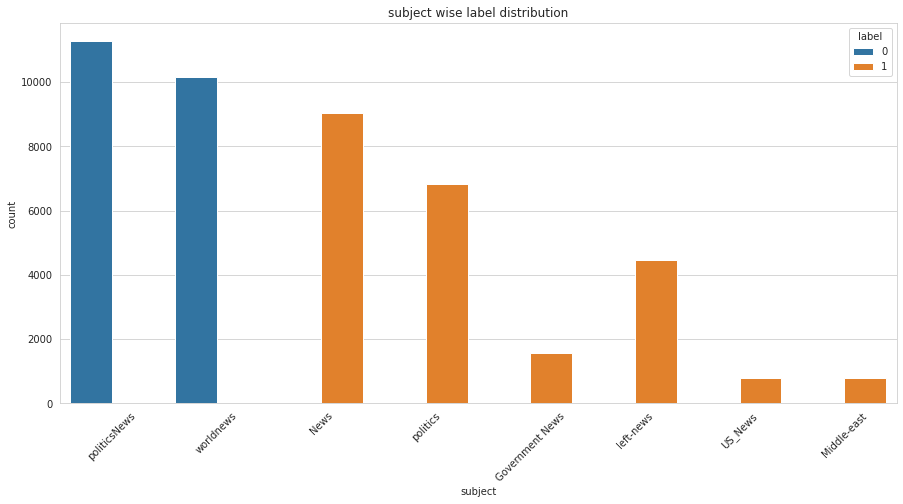

In [24]:
plotter(converted_fake_news_df, 'subject', 'label', title='subject-wise-label-distribution')

In [15]:
converted_fake_news_df.label.value_counts()

1    23481
0    21417
Name: label, dtype: int64

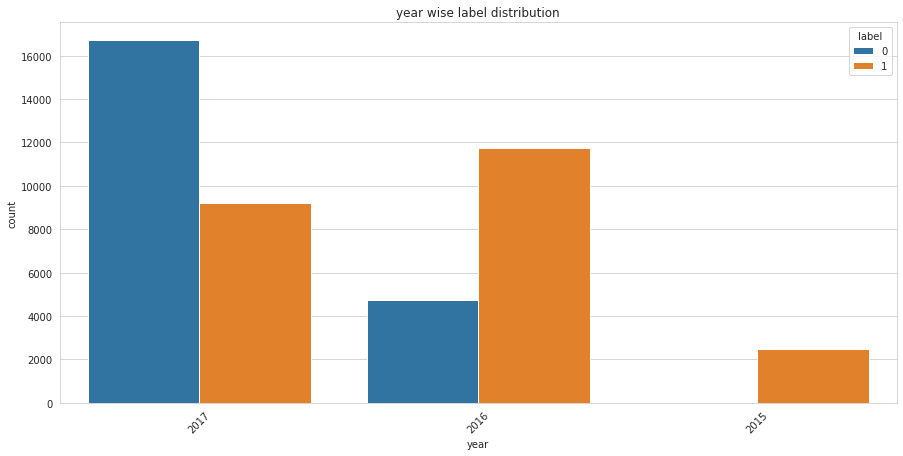

In [26]:
plotter(converted_fake_news_df, 'year', 'label', title="year-wise-label-distribution")

In [16]:
month = """November,
October,
September,
December,
May,
July
March,
January,
February,
April,
June,
August"""
month_dict = {}
for m in month.split('\n'):
  m = m.replace(',','')
  month_dict[m[:3]] = m

In [17]:
month_dict

{'Apr': 'April',
 'Aug': 'August',
 'Dec': 'December',
 'Feb': 'February',
 'Jan': 'January',
 'Jul': 'July',
 'Jun': 'June',
 'Mar': 'March',
 'May': 'May',
 'Nov': 'November',
 'Oct': 'October',
 'Sep': 'September'}

In [18]:
converted_fake_news_df['month_cln'] = converted_fake_news_df['month'].replace(month_dict)
converted_fake_news_df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
23476  McPain: John McCain Furious That Iran Treated ...   
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
23479  How to Blow $700 Million: Al Jazeera America F...   
23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
23476  21st Century Wire says As 21WIRE reported earl...   Middle-east   
23477  21st Century Wire says It s a familiar theme. ...   Middle-east   
23478  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
23479  21st Century Wire says Al Jazeera America will...   Middle-east   
23480  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

              date  label  year     month month_cln  
0      December 31      0  2017  December  December  
1      December 29      0  2017  December  December  
2      December 31      0  2017  December  December  
3      December 30      0  2017  December  December  
4      December 29      0  2017  December  December  
...            ...    ...   ...       ...       ...  
23476   January 16      1  2016   January   January  
23477   January 16      1  2016   January   January  
23478   January 15      1  2016   January   January  
23479   January 14      1  2016   January   January  
23480   January 12      1  2016   January   January  

[44898 rows x 8 columns]

In [19]:
def visual_data(df):
  counts = df['month_cln'].value_counts()
  res = df[~df['month_cln'].isin(counts[counts < 1000].index)]
  return res

In [20]:
visual_data(converted_fake_news_df).month_cln.value_counts()

November     5536
October      5476
September    5199
December     4614
March        3336
January      3106
May          3076
April        3034
February     2922
June         2896
August       2829
July         2829
Name: month_cln, dtype: int64

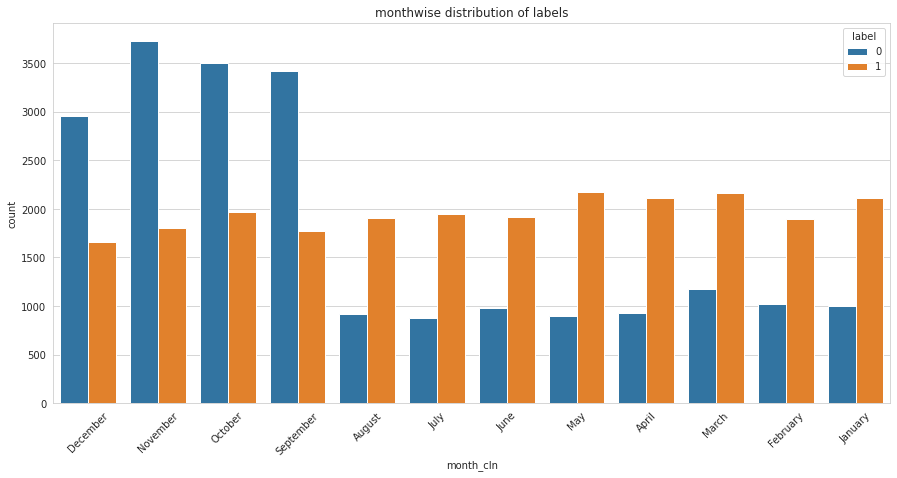

In [32]:
plotter(visual_data(converted_fake_news_df), 'month_cln', 'label', 'monthwise-distribution-of-labels')

##### *post-processing liar-df to r**emove extra rows** and make merge on labels as specified in [1.1]*



```
1: unreliable
0: reliable
```

In [21]:
def post_process_df(df, drop_row_cols=None, label_encoding=None,
                    merge_cols=None, replace_col_names=None,
                    req_col_names=['text', 'title', 'label']):
  
  df = df.fillna(' ')

  if drop_row_cols:
    for col in drop_row_cols:
      df = df[df.label != col]

  if label_encoding:
    df.label.replace(to_replace=label_encoding, inplace=True)

  if merge_cols:
    df['text'] = df[merge_cols].agg('-'.join, axis=1)

  if replace_col_names:
    for a,b in replace_col_names.items():
      df[b] = df[a]
  
  df = df.drop(columns=[col for col in df.columns if col not in req_col_names])
  df = df[req_col_names]
  return df

In [22]:
converted_fake_news_df = post_process_df(converted_fake_news_df,
                merge_cols=['text','year','month','subject'])
converted_fake_news_df

text  \
0      WASHINGTON (Reuters) - The head of a conservat...   
1      WASHINGTON (Reuters) - Transgender people will...   
2      WASHINGTON (Reuters) - The special counsel inv...   
3      WASHINGTON (Reuters) - Trump campaign adviser ...   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...   
...                                                  ...   
23476  21st Century Wire says As 21WIRE reported earl...   
23477  21st Century Wire says It s a familiar theme. ...   
23478  Patrick Henningsen  21st Century WireRemember ...   
23479  21st Century Wire says Al Jazeera America will...   
23480  21st Century Wire says As 21WIRE predicted in ...   

                                                   title  label  
0      As U.S. budget fight looms, Republicans flip t...      0  
1      U.S. military to accept transgender recruits o...      0  
2      Senior U.S. Republican senator: 'Let Mr. Muell...      0  
3      FBI Russia probe helped by Australian diplomat...      0  
4      Trump wants Postal Service to charge 'much mor...      0  
...                                                  ...    ...  
23476  McPain: John McCain Furious That Iran Treated ...      1  
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...      1  
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...      1  
23479  How to Blow $700 Million: Al Jazeera America F...      1  
23480  10 U.S. Navy Sailors Held by Iranian Military ...      1  

[44898 rows x 3 columns]

In [23]:
# analysis over df schema
def schema_check(df, y, plot=False, title=None, plot_path="insights_and_outputs/plots/"):
    print(title)
    print(df.columns)
    save_path = os.path.join(root_path, data_path, plot_path, f"{title}.png")
    counts = df[y].value_counts()
    print(counts)
    if plot:
      counts.plot.bar()
      plt.title(title)
      plt.xlabel("labels")
      
      plt.savefig(save_path)
      plt.show()    
    print("\n--------------------------------------")

kaggle
Index(['title', 'text', 'label'], dtype='object')
1    10413
0    10387
Name: label, dtype: int64


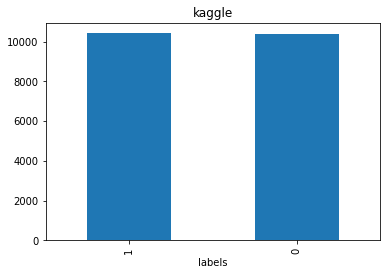


--------------------------------------
fake news
Index(['text', 'title', 'label'], dtype='object')
1    23481
0    21417
Name: label, dtype: int64


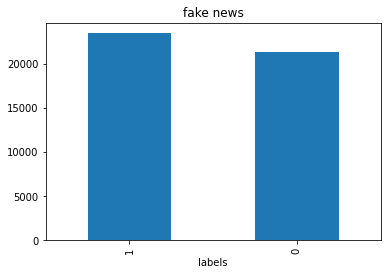


--------------------------------------


In [24]:
schema_check(converted_kaggle_df,"label", plot=True,title='kaggle')
schema_check(converted_fake_news_df,"label", plot=True,title="fake news")

***For better interpretability; a seperate column with df type will be saved***

In [25]:
from collections import Counter

In [26]:
def merge_dataframe(df_dict):
  name_col = []
  merged_df = pd.DataFrame()
  for name, df in df_dict.items():
    names = [name]*len(df)
    name_col.extend(names)
    if len(merged_df):
      merged_df = pd.concat([merged_df, df])
    else:
      merged_df = deepcopy(df)
  merged_df = merged_df.reset_index()
  merged_df.drop(columns=["index"], inplace=True)
  merged_df['data_type'] = pd.Series(name_col)
  return merged_df

In [27]:
df_dict = {"kaggle":converted_kaggle_df,
           "fake news":converted_fake_news_df,}
          # "liar":converted_liar_df}
merged_df = merge_dataframe(df_dict)

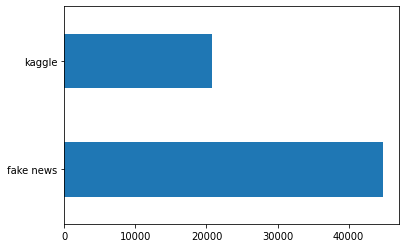

In [28]:
merged_df.data_type.value_counts().plot.barh()

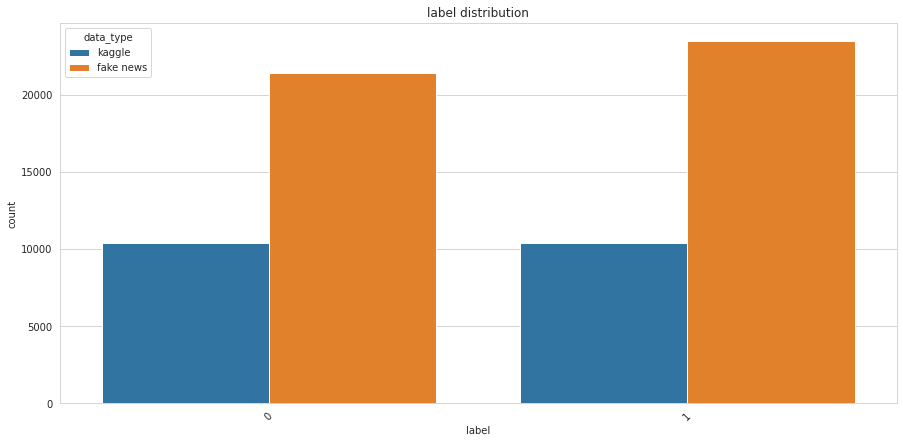

In [42]:
plotter(merged_df, 'label', hue="data_type", title="label-distribution")

In [29]:
merged_df

title  \
0      House Dem Aide: We Didn’t Even See Comey’s Let...   
1      FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2                      Why the Truth Might Get You Fired   
3      15 Civilians Killed In Single US Airstrike Hav...   
4      Iranian woman jailed for fictional unpublished...   
...                                                  ...   
65693  McPain: John McCain Furious That Iran Treated ...   
65694  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
65695  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
65696  How to Blow $700 Million: Al Jazeera America F...   
65697  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text  label  data_type  
0      House Dem Aide: We Didn’t Even See Comey’s Let...      1     kaggle  
1      Ever get the feeling your life circles the rou...      0     kaggle  
2      Why the Truth Might Get You Fired October 29, ...      1     kaggle  
3      Videos 15 Civilians Killed In Single US Airstr...      1     kaggle  
4      Print \nAn Iranian woman has been sentenced to...      1     kaggle  
...                                                  ...    ...        ...  
65693  21st Century Wire says As 21WIRE reported earl...      1  fake news  
65694  21st Century Wire says It s a familiar theme. ...      1  fake news  
65695  Patrick Henningsen  21st Century WireRemember ...      1  fake news  
65696  21st Century Wire says Al Jazeera America will...      1  fake news  
65697  21st Century Wire says As 21WIRE predicted in ...      1  fake news  

[65698 rows x 4 columns]

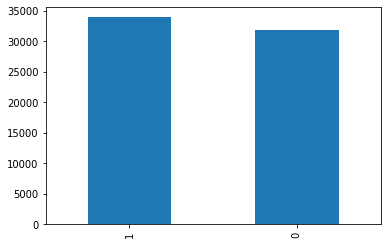

In [30]:
merged_df.label.value_counts().plot.bar()

In [31]:
save_path = "prepared_data/final_merged_dataframe_kaggle_fakeNews.csv"

In [32]:
merged_df.to_csv(os.path.join(root_path, data_path, save_path), index=False)

## **DATA LEVEL**



```
step 1: clean dataset
step 2: Word cloud visuals
step 3: stemming and pre-processing
```



In [33]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import re, os
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection
import sklearn.preprocessing as preproc
from sklearn.feature_extraction import text
import pickle
import warnings
warnings.filterwarnings("ignore")

In [34]:
root_path = "/content/drive/MyDrive/Final" 
data_path = "data modeling"
save_path = "prepared_data/final_merged_dataframe_kaggle_fakeNews.csv"
load_path = os.path.join(root_path, data_path, save_path)
merged_df = pd.read_csv(load_path)

In [ ]:
#k = 100
#merged_df = pd.concat([merged_df.iloc[:k, :], merged_df.iloc[-k:, :]])

In [35]:
merged_df.shape

(65698, 4)

In [59]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [36]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [37]:
merged_df = merged_df.dropna(subset=['text'])

In [38]:
merged_df.isna().sum()

title        558
text           0
label          0
data_type      0
dtype: int64

In [39]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
        
    return text

In [40]:
merged_df['Text_Cleaned'] = list(map(clean_text, merged_df.text))

In [41]:
merged_df

title  \
0      House Dem Aide: We Didn’t Even See Comey’s Let...   
1      FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2                      Why the Truth Might Get You Fired   
3      15 Civilians Killed In Single US Airstrike Hav...   
4      Iranian woman jailed for fictional unpublished...   
...                                                  ...   
65693  McPain: John McCain Furious That Iran Treated ...   
65694  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
65695  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
65696  How to Blow $700 Million: Al Jazeera America F...   
65697  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text  label  data_type  \
0      House Dem Aide: We Didn’t Even See Comey’s Let...      1     kaggle   
1      Ever get the feeling your life circles the rou...      0     kaggle   
2      Why the Truth Might Get You Fired October 29, ...      1     kaggle   
3      Videos 15 Civilians Killed In Single US Airstr...      1     kaggle   
4      Print \nAn Iranian woman has been sentenced to...      1     kaggle   
...                                                  ...    ...        ...   
65693  21st Century Wire says As 21WIRE reported earl...      1  fake news   
65694  21st Century Wire says It s a familiar theme. ...      1  fake news   
65695  Patrick Henningsen  21st Century WireRemember ...      1  fake news   
65696  21st Century Wire says Al Jazeera America will...      1  fake news   
65697  21st Century Wire says As 21WIRE predicted in ...      1  fake news   

                                            Text_Cleaned  
0      [house, dem, aide, didn, ’, t, even, see, come...  
1      [ever, get, feeling, life, circles, roundabout...  
2      [truth, might, get, fired, october, 29, 2016, ...  
3      [videos, 15, civilians, killed, single, us, ai...  
4      [print, iranian, woman, sentenced, six, years,...  
...                                                  ...  
65693  [21st, century, wire, says, 21wire, reported, ...  
65694  [21st, century, wire, says, familiar, theme, w...  
65695  [patrick, henningsen, 21st, century, wireremem...  
65696  [21st, century, wire, says, al, jazeera, ameri...  
65697  [21st, century, wire, says, 21wire, predicted,...  

[65659 rows x 5 columns]

### Visuals

In [63]:
import wordcloud

wordcloud.__version__

'1.5.0'

In [64]:
from wordcloud import WordCloud, STOPWORDS

In [65]:
# initialize the word cloud
wordcloud = WordCloud(background_color='black', width=800, height=600)

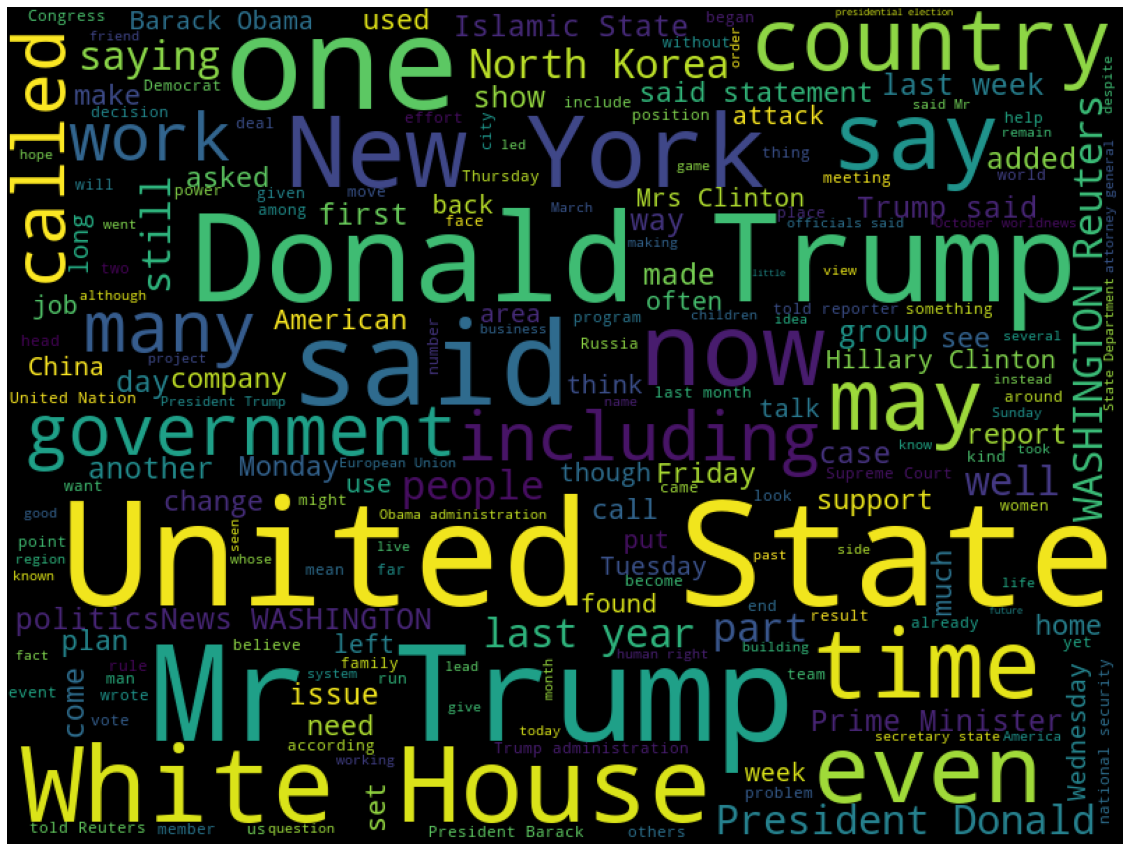

In [66]:
# reliable news (0)
reliable_news = " ".join(merged_df[merged_df['label']==0]['text'])
wc = wordcloud.generate(reliable_news)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.savefig(f"{root_path}/{data_path}/insights_and_outputs/word_clouds/reliable_keywords.png")
plt.show()

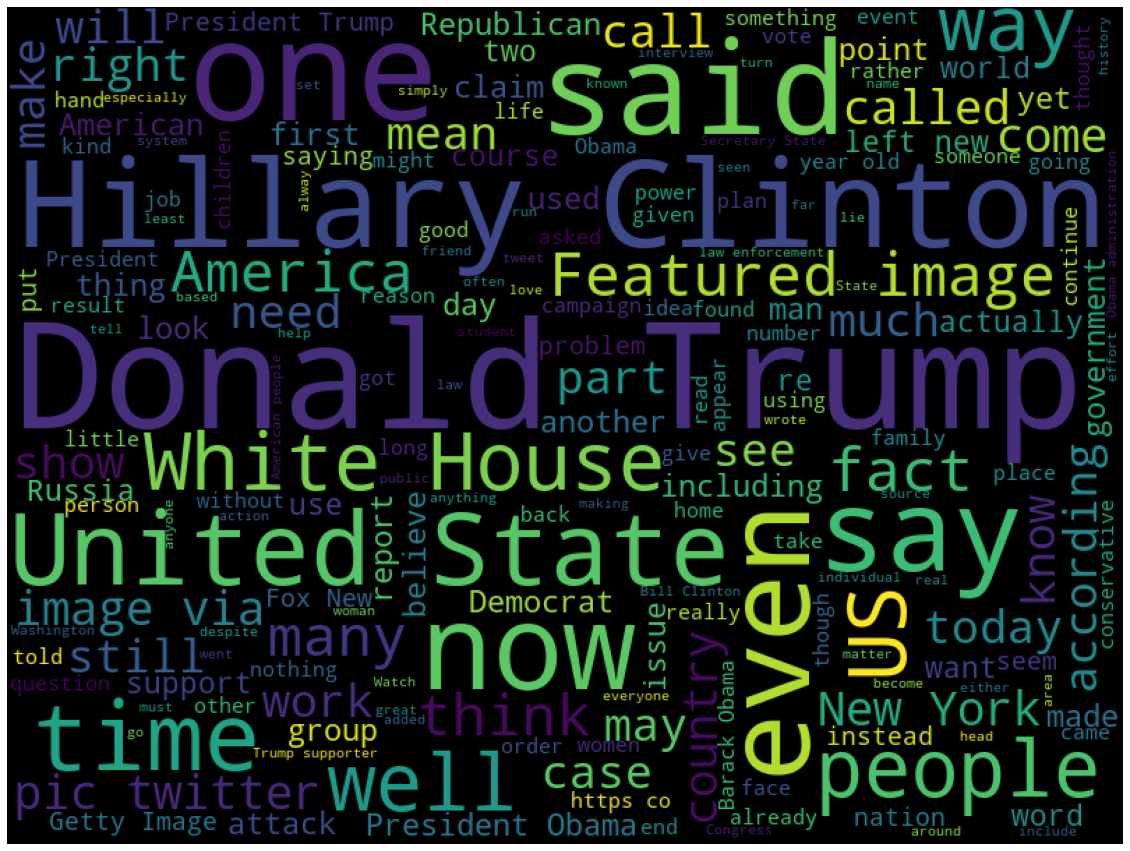

In [67]:
# unreliable news (1)
unreliable_news  = ' '.join(merged_df[merged_df['label']==1]['text'])
wc= wordcloud.generate(unreliable_news)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.savefig(f"{root_path}/{data_path}/insights_and_outputs/word_clouds/unreliable_keywords.png")
plt.show()

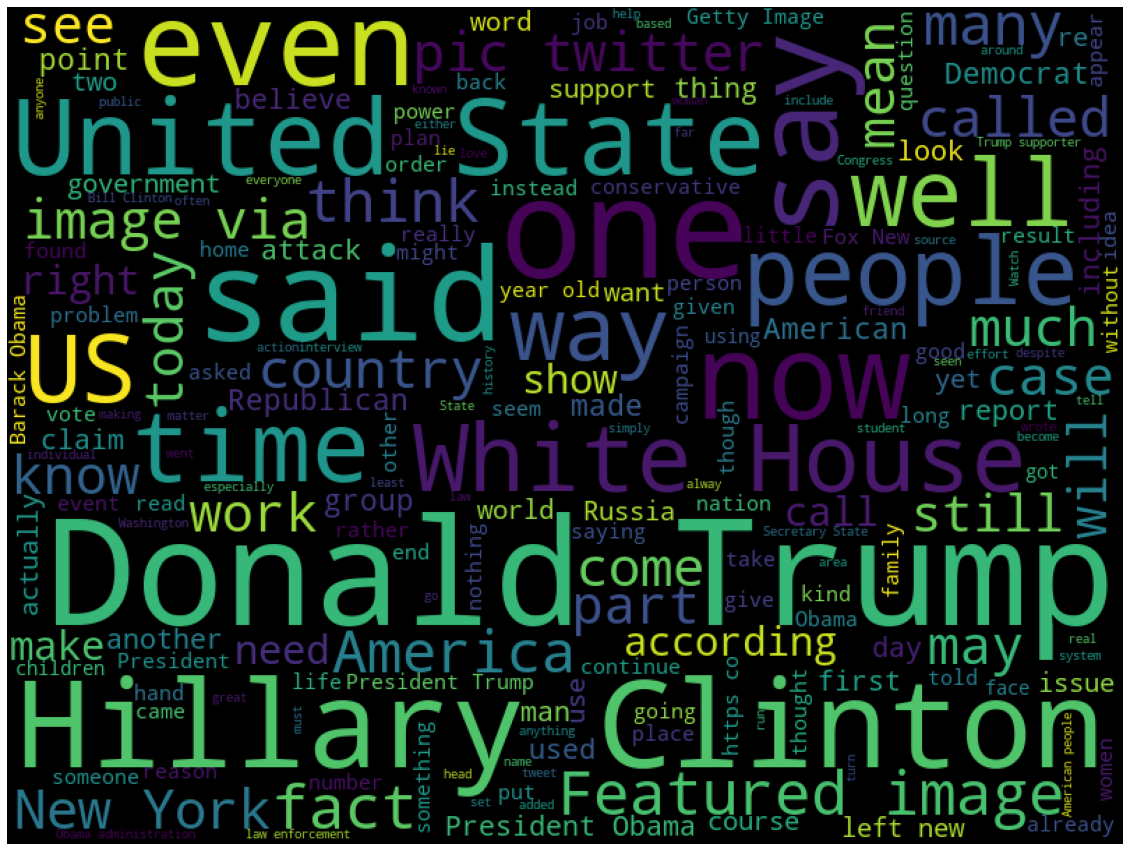

In [68]:
# reliable news for kaggle (1)
reliable_news  = ' '.join(merged_df[
                                      (merged_df['label']==0) & 
                                      (merged_df['data_type']=='kaggle')
                                      ]['text'])
wc= wordcloud.generate(unreliable_news)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.savefig(f"{root_path}/{data_path}/insights_and_outputs/word_clouds/reliable_keywords_kaggle.png")
plt.show()

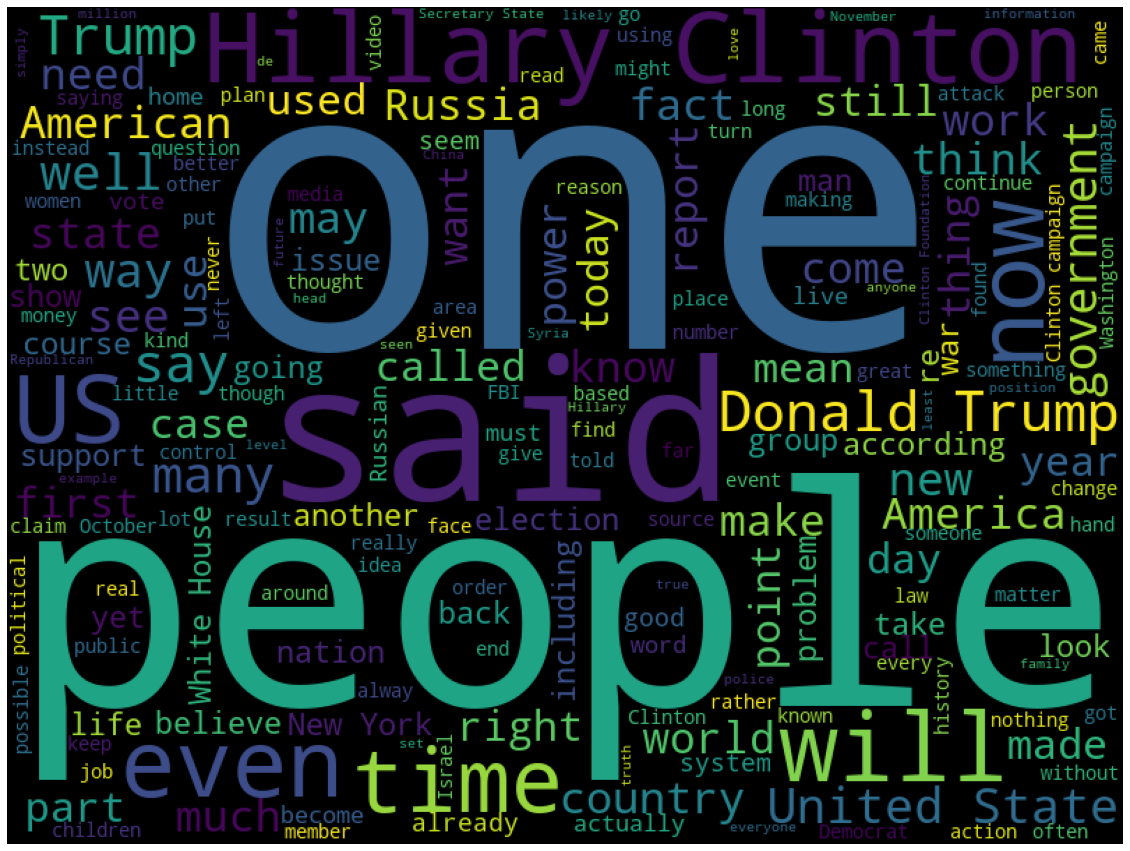

In [69]:
# unreliable news for kaggle (1)
unreliable_news  = ' '.join(merged_df[
                                      (merged_df['label']==1) & 
                                      (merged_df['data_type']=='kaggle')
                                      ]['text'])
wc= wordcloud.generate(unreliable_news)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.savefig(f"{root_path}/{data_path}/insights_and_outputs/word_clouds/unreliable_keywords_kaggle.png")
plt.show()

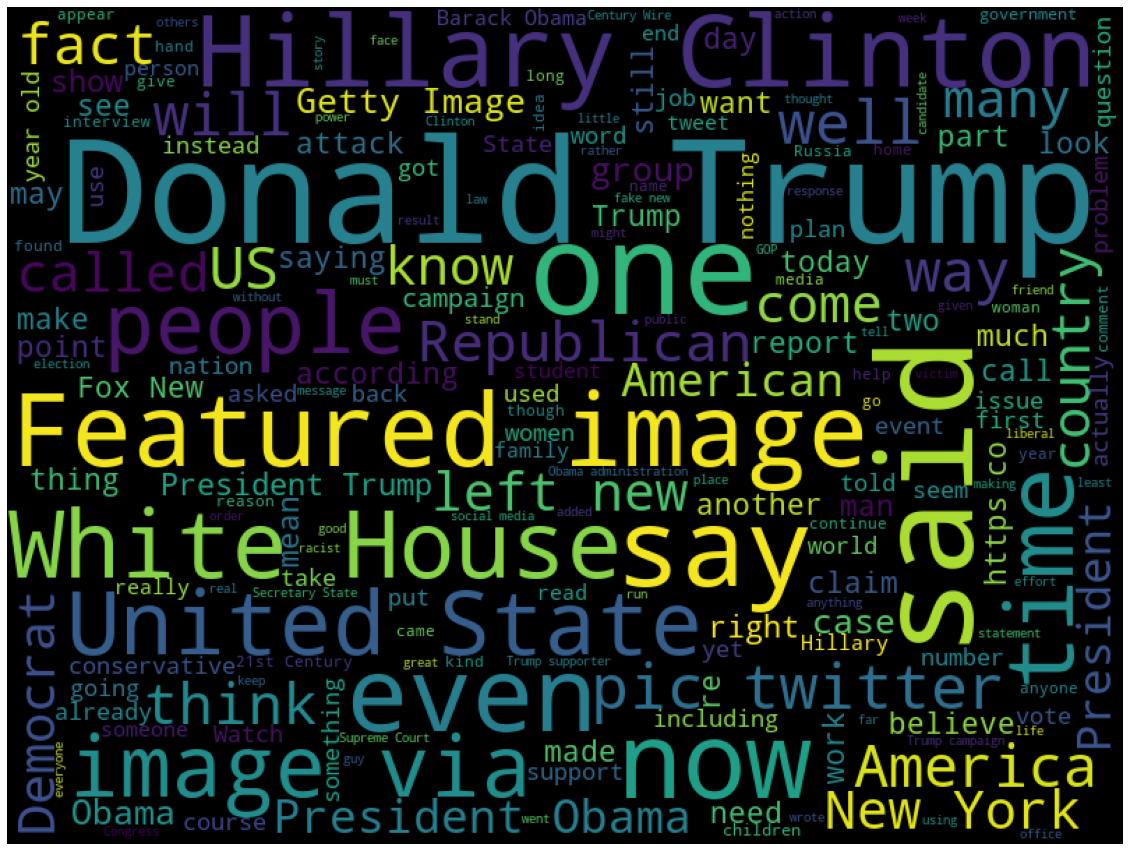

In [70]:
# reliable news for fake news (1)
reliable_news  = ' '.join(merged_df[
                                      (merged_df['label']==1) & 
                                      (merged_df['data_type']=='fake news')
                                      ]['text'])
wc= wordcloud.generate(reliable_news)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.savefig(f"{root_path}/{data_path}/insights_and_outputs/word_clouds/unreliable_keywords_fakeNews.png")
plt.show()

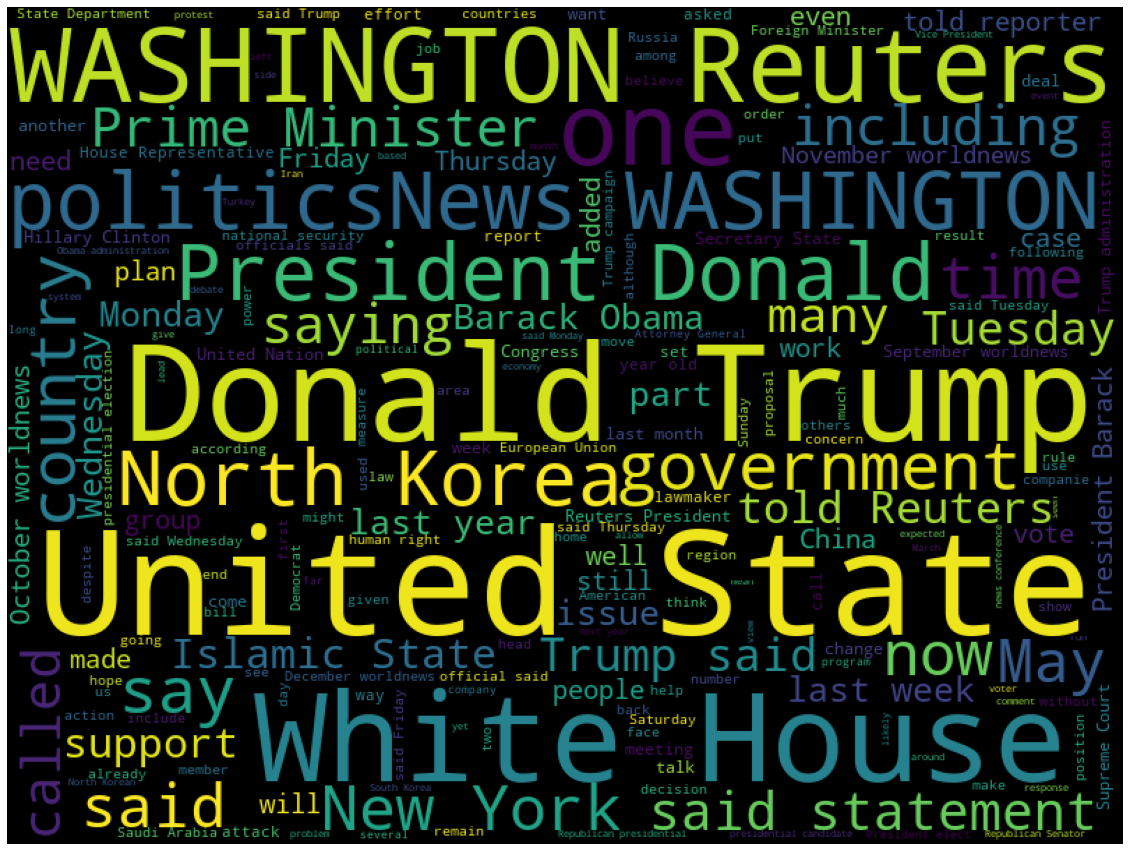

In [71]:
# unreliable news for fake news (1)
unreliable_news  = ' '.join(merged_df[
                                      (merged_df['label']==0) & 
                                      (merged_df['data_type']=='fake news')
                                      ]['text'])
wc= wordcloud.generate(unreliable_news)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.savefig(f"{root_path}/{data_path}/insights_and_outputs/word_clouds/reliable_keywords_fakeNews.png")
plt.show()

In [72]:
def plot_top_ngrams(corpus, title, ylabel, xlabel="Number of Occurenes", n =2):
    true_b = (pd.Series(nltk.ngrams(corpus.split(), n)).value_counts())[:20]
    true_b.sort_values().plot.barh(color='blue', width=.9, figsize=(12,8))
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.savefig(f"top {n}.png")
    plt.savefig(f"{root_path}/{data_path}/insights_and_outputs/plots/{title.replace(' ','-')}.png")
    plt.show()

In [73]:
joined_cleaned_corpus = ''
for row in merged_df['Text_Cleaned']:
  joined_cleaned_corpus += ' '.join(clean_text(' '.join(row))).replace("'","").replace('"','').strip().replace("  "," ")

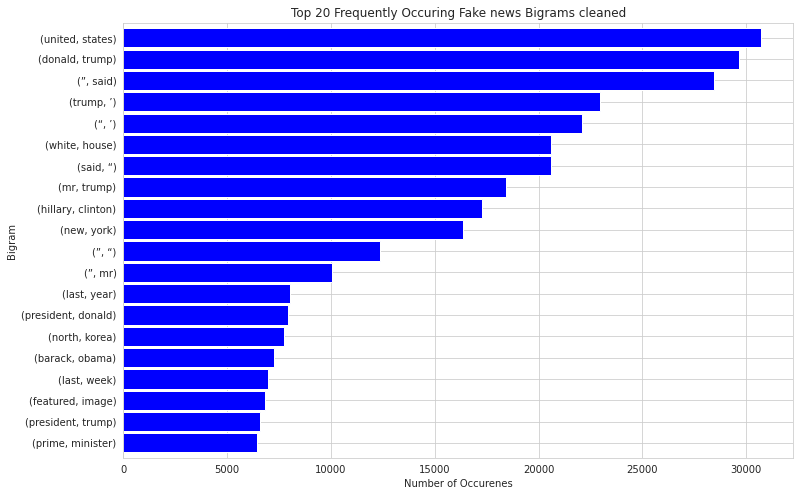

In [74]:
plot_top_ngrams(joined_cleaned_corpus, 'Top 20 Frequently Occuring Fake news Bigrams cleaned', "Bigram", n=2)

In [75]:
def lemmatized_words(text):
    lemm = nltk.stem.WordNetLemmatizer()
    merged_df['lemmatized_text'] = list(map(lambda word:
                                  list(map(lemm.lemmatize, word)),
                                     merged_df.Text_Cleaned))

lemmatized_words(merged_df.Text_Cleaned)

In [77]:
pd.set_option('max_colwidth', 500)
merged_df[['text', 'label', 'Text_Cleaned', 'lemmatized_text']].sample(3)

text  \
40140  QAMISHLI, Syria (Reuters) - Syrians voted on Friday in an election organized by the Kurdish-led authorities of northern Syria, the start of a three-phase process to set up new governing institutions that aim to shore up regional autonomy.  Today comes as a historical day for us. The people are choosing their way of life, politics, economy,  said Renas Ahmed, 25, among several dozen people casting their vote for the local community representatives being elected.  Voters were picking leaders f...   
56659                                                                                                                                                                                                                                                                                                                                                                                                                                        This ad by the Republican Party nails Hillary on the lies: -2016-Feb-politics   
54510  A post on Reddit citing an investigative journalist reads as follows:  RED ALERT! JIM STONE DISCOVERS SOROS BOT FUNDING JILL STEIN S RECOUNT CAMPAIGN AT RATE OF $160,000/HOUR!!!! DO NOT FALL ASLEEP AT THE WHEEL, BIG TIME F*CKERY IS AFOOT!!! According to the post a donations to Jill Stein s election recount campaign are being made at a steady rate of $160,000 on the hour every hour of the day.The constant rate of donation, 24 hours a day, suggest that a computer program is being used to post ...   

       label  \
40140      0   
56659      1   
54510      1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Text_Cleaned  \
40140  [qamishli, syria, reuters, syrians, voted, friday, election, organized, kurdish, led, authorities, northern, syria, start, three, phase, process, set, new, governing, institutions, aim, shore, regional, autonomy, today, comes, historical, day, us, people, choosing, way, life, politics, economy, said, renas, ahmed, 25, among, several, dozen, people, casting, vote, local, community, representatives, elected, voters, picking, leaders, 3, 700, communes, spread, across, three, regions, north, kur...   
56659                                                                                                                                                                                                                                                                                                                                                                                                                                                   [ad, republican, party, nails, hillary, lies, 2016, feb, politics]   
54510  [post, reddit, citing, investigative, journalist, reads, follows, red, alert, jim, stone, discovers, soros, bot, funding, jill, stein, recount, campaign, rate, 160, 000, hour, fall, asleep, wheel, big, time, f, ckery, afoot, according, post, donations, jill, stein, election, recount, campaign, made, steady, rate, 160, 000, hour, every, hour, day, constant, rate, donation, 24, hours, day, suggest, computer, program, used, post, donations, opposed, real, people, making, grassroots, donation, h...   

                                                                                                                                                                                                                                                                                                                                                                   

### Vectorization

In [67]:
bow_converter = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
x = bow_converter.fit_transform(merged_df['Text_Cleaned'])

words = bow_converter.get_feature_names()
len(words)

223065

In [68]:
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2], lowercase=False) 
x2 = bigram_converter.fit_transform(merged_df['Text_Cleaned'])
bigrams = bigram_converter.get_feature_names()
len(bigrams)

7129330

In [69]:
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False) 
x3 = trigram_converter.fit_transform(merged_df['Text_Cleaned'])
trigrams = trigram_converter.get_feature_names()
len(trigrams)

14318344

In [70]:
print(len(words), len(bigrams), len(trigrams))

223065 7129330 14318344


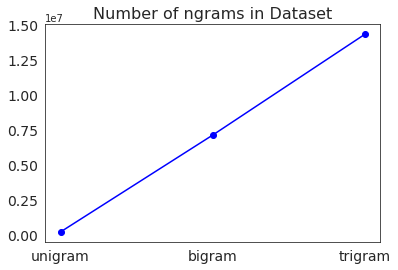

In [71]:
sns.set_style("white")
counts = [len(words), len(bigrams), len(trigrams)]
plt.plot(counts, color='blue')
plt.plot(counts, 'bo')
plt.xticks(range(3), ['unigram', 'bigram', 'trigram'])
plt.tick_params(labelsize=14)
plt.title('Number of ngrams in Dataset', {'fontsize':16})
plt.savefig(f"{root_path}/{data_path}/insights_and_outputs/plots/ngrams-count-comparison.png")
plt.show()

In [72]:
del words
del bigrams
del trigrams

### Data split

In [42]:
training_data, test_data = sklearn.model_selection.train_test_split(merged_df, train_size = 0.7, random_state=42)

In [43]:
print(training_data.shape)
print(test_data.shape)

(45961, 5)
(19698, 5)


### Fitting data in vectorizer

In [44]:
# bow: bag of words
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False) 

In [45]:
X_tr_bow = bow_transform.fit_transform(training_data['Text_Cleaned'])

In [46]:
X_tr_bow.shape

(45961, 10664017)

In [47]:
X_te_bow = bow_transform.transform(test_data['Text_Cleaned'])

In [48]:
y_tr = training_data['label']
y_te = test_data['label']

In [49]:
# TF-IDF Techique : The term frequency-inverse document frequency (TF-IDF) statistic determines how related a word is to a document in a collection

tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow)

In [50]:
X_te_tfidf = tfidf_transform.transform(X_te_bow)

In [51]:
X_tr_tfidf.shape

(45961, 10664017)

# Training on [BOW, Tf-idf]

In [52]:
def simple_logistic_classify(x, y, description, _C=100.0, mode='train', model=None):
  if mode=="train" and model is None:
    model = LogisticRegression(C=_C).fit(x, y)
  score = model.score(x, y)
  print(f'{mode} Score with', description, 'features', score)
  return model

In [53]:
model_bow = simple_logistic_classify(X_tr_bow, y_tr, 'bow')

model_tfidf = simple_logistic_classify(X_tr_tfidf, y_tr, 'tf-idf')

train Score with bow features 0.9999782424229238
train Score with tf-idf features 0.9999782424229238


# Testing

In [54]:
model_bow = simple_logistic_classify(X_te_bow, y_te, 'bow',mode='test', model=model_bow)
model_tfidf = simple_logistic_classify(X_te_tfidf, y_te, 'tf-idf',mode='test',model=model_tfidf)

test Score with bow features 0.9608082038785664
test Score with tf-idf features 0.9623312011371713




```
We will be saving the tf-idf based model for inferencing
```



# model saving

In [55]:
import joblib, os

save_path = "web-app/utils/"
model_path = os.path.join(root_path, save_path, 'tfidf_model.pkl')
vectorizer_path = os.path.join(root_path, save_path, 'tfidf_vectorizer.pkl')

In [56]:
saved_model=joblib.dump(model_tfidf, model_path)
tfidf_vectorizer = joblib.dump(tfidf_transform, vectorizer_path)

In [57]:
import dill

In [58]:
f = open(os.path.join(root_path, save_path, "bow_convertor.pickle"), 'wb')
dill.dump(bow_transform, f)
f.close()

# load testing

In [59]:
import pickle
import os

In [60]:
# The base path here
root_path = "/content/drive/MyDrive/Final" 
save_path = "web-app/utils/"

In [61]:
# laoded bow
f = open("/content/drive/MyDrive/Final/web-app/utils/bow_convertor.pkl", 'rb')   
bow = dill.load(f)

In [62]:
# loaded vectorizer
vectorizer_path = os.path.join(root_path, save_path, 'tfidf_vectorizer.pkl')
test_vectorizer = joblib.load(vectorizer_path)      

In [63]:
model_path = os.path.join(root_path, save_path, 'tfidf_model.pkl')
loaded_model = joblib.load(model_path)

In [64]:
X_te_bow = bow.transform(['hello'])# test_data['Text_Cleaned'])

In [65]:
xtest_test = test_vectorizer.transform(X_te_bow)

In [66]:
xtest_test.shape

(1, 10664017)

In [67]:
loaded_model.predict(xtest_test).item()

1

In [68]:
xtest_test.shape

(1, 10664017)

In [69]:
test_data['text'].iloc[0]

'Only days after the worst mass shooting in the nation s history happened against the LGBT community, the GOP decided they could go back to being discriminatory.One would think they d wait at least a week, but apparently three days seemed long enough to mourn the loss of those who perished at Pulse nightclub in Orlando, Florida, because according to Vanity Fair:Republican leaders in the House of Representatives blocked a vote on a proposal that would ensure federal contractors can t discriminate against employees on the basis of sexual orientation or gender identification.That s right, you read that correctly, they seem to think it s perfectly acceptable for federal contractors to be able to fire someone for being gay.According to The Hill:Rep. Sean Patrick Maloney (D-N.Y.), who is gay, filed an amendment to a Defense Department spending bill that would enforce a 2014 executive order prohibiting discrimination against LGBT people.Yet, the House Rules Committee didn t see it worthy of c

In [70]:
test_data['Text_Cleaned'].iloc[0]

['days',
 'worst',
 'mass',
 'shooting',
 'nation',
 'history',
 'happened',
 'lgbt',
 'community',
 'gop',
 'decided',
 'could',
 'go',
 'back',
 'discriminatory',
 'one',
 'would',
 'think',
 'wait',
 'least',
 'week',
 'apparently',
 'three',
 'days',
 'seemed',
 'long',
 'enough',
 'mourn',
 'loss',
 'perished',
 'pulse',
 'nightclub',
 'orlando',
 'florida',
 'according',
 'vanity',
 'fair',
 'republican',
 'leaders',
 'house',
 'representatives',
 'blocked',
 'vote',
 'proposal',
 'would',
 'ensure',
 'federal',
 'contractors',
 'discriminate',
 'employees',
 'basis',
 'sexual',
 'orientation',
 'gender',
 'identification',
 'right',
 'read',
 'correctly',
 'seem',
 'think',
 'perfectly',
 'acceptable',
 'federal',
 'contractors',
 'able',
 'fire',
 'someone',
 'gay',
 'according',
 'hill',
 'rep',
 'sean',
 'patrick',
 'maloney',
 'n',
 'gay',
 'filed',
 'amendment',
 'defense',
 'department',
 'spending',
 'bill',
 'would',
 'enforce',
 '2014',
 'executive',
 'order',
 'prohibi